# Imports for Simulation and Visualiation

In [2]:
from random import randint, shuffle
import time
import matplotlib.pyplot as plt
import numpy as np

### Class Game
- Attributes
    - PayoffMatrix
        : Payoff Matrix of two player Game
- Methods
    - findSDSE
        : Computes Strong Dominant Strategy Equilibrium if it exists.
    - findMSNE
        : Computes MSNE using indifference priciple.

In [3]:
class game:
    def __init__(self):
        food = (MAX_FOOD_PER_ROUND + MIN_FOOD_PER_ROUND)//2
        self.payoffMatrix = [ 
                            [[(food//2) - ENERGY_LOSS_FROM_FIGHTING, (food//2) - ENERGY_LOSS_FROM_FIGHTING],[food,0]],
                            [[0, food],[(food//2), (food//2)]]
                            ]
#     Arguments : None, Return: list of SDSE strategy
    def findSDSE(self):
        P1 = []
        P2 = []
        if self.payoffMatrix[0][0][0] > self.payoffMatrix[1][0][0] and self.payoffMatrix[0][1][0] > self.payoffMatrix[1][1][0]:
            P1.append(0)
        if self.payoffMatrix[0][0][0] < self.payoffMatrix[1][0][0] and self.payoffMatrix[0][1][0] < self.payoffMatrix[1][1][0]:
            P1.appendp(1)
        if self.payoffMatrix[0][0][1] > self.payoffMatrix[0][1][1] and self.payoffMatrix[1][0][1] > self.payoffMatrix[1][1][1]:
            P2.append(0)
        if self.payoffMatrix[0][0][1] < self.payoffMatrix[0][1][1] and self.payoffMatrix[1][0][1] < self.payoffMatrix[1][1][1]:
            P2.append(1)
        ret = [(x, y) for x in P1 for y in P2]
        return ret

#   Arguments: None, Return list of probability distribution over strategy for player 1 and player 2
    def findMSNE(self):

        SDSE = self.findSDSE()
        p = np.zeros(2)
        q = np.zeros(2)
        if(len(SDSE) > 0):
            p[SDSE[0][0]] = 1
            q[SDSE[0][1]] = 1
            return [p,q]
        
#         row player Indifference Condition
        a = np.array([[1, 1], [self.payoffMatrix[0][0][0] - self.payoffMatrix[1][0][0], self.payoffMatrix[0][1][0] - self.payoffMatrix[1][1][0]] ])
        b = np.array([1, 0])
        q = np.linalg.solve(a, b)
        
#         col player Indifference Condition
        a = np.array([[1, 1], [self.payoffMatrix[0][0][1] - self.payoffMatrix[0][1][1], self.payoffMatrix[1][0][1] - self.payoffMatrix[1][1][1]] ])
        b = np.array([1, 0])
        p = np.linalg.solve(a, b) 
        return [p,q]
        

#### Global intitial Condtion
1. STARTING_DOVES
    : The number of players who are Doves in the beginning
2. STARTING_HAWKS
    : The number of players who are Doves in the beginning
3. ROUNDS
    : Number of Rounds in the simulation
4. STARTING_ENERGY
    : The amount of energy with which each player starts the game.
5. MIN_FOOD_PER_ROUND
    : Min energy available per food.
6. MAX_FOOD_PER_ROUND
    : Max energy available per food.
7. MAX_FOOD_APPEARANCE
    : Max number of food appearance per round
8. ENERGY_REQUIRED_FOR_REPRODUCTION
    : Minimum energy required to reproduce
9. ENERGY_LOSS_PER_ROUND
    : Energy spent for surviving a round
10. ENERGY_LOSS_FROM_FIGHTING
    : Energy spent over fighting
11. ENERGY_REQUIRED_FOR_LIVING
    : Minimum energy required to remain alive
    
#### Model Formulation

1. Game Starts with gameInit(), a function which initialize all the agents. These agents are the players in this game and they can be either HAWK or DOVE. 
2. Then rounds start, while rounds <= ROUNDS **and** Agents Remaining >=2:
    1. Call AwakenAgents(), set the state of agent to **Awake State**.
    2. Generate the random food for the current round.
    3. Shuffle the agents for random pairing.
    4. Then pair the agents and let them compete over the food, However the max number of food appearance is limited by MAX_FOOD_APPEARANCE.
    5. Then the agents pay the cost of living a round.
    6. Cull() is called and every agent with energy less than ENERGY_REQUIRED_FOR_LIVING is deleted from the simulation.
    7. The remaing of the agents then reproduce if they have energy greater than ENERGY_REQUIRED_FOR_REPRODUCTION.
    8. Data is collected stored for further analysis.
3. After the simulation ends we analyze and compare the data collected with the  theoretically calculated MSNE.
    

In [92]:
STARTING_DOVES = 1000
STARTING_HAWKS = 1000
STARTING_POPULATION = STARTING_HAWKS + STARTING_DOVES

ROUNDS = 200
STARTING_ENERGY = 100

MIN_FOOD_PER_ROUND = 60
MAX_FOOD_PER_ROUND = 70
MAX_FOOD_APPEARANCE = 1000 # this tells how much max food can be found
ENERGY_REQUIRED_FOR_REPRODUCTION = 250
ENERGY_LOSS_PER_ROUND = 4
ENERGY_LOSS_FROM_FIGHTING = 50-10
ENERGY_REQUIRED_FOR_LIVING = 10

STATUS_ACTIVE = "active"
STATUS_ASLEEP = "asleep"

TYPE_HAWK = "hawk"
TYPE_DOVE = "dove"

agents = []

# Graph stuff
graph_hawk_points = []
graph_dove_points = []

AGENT_ID = 1
class Agent:
    
    def __init__(self, agent_type, status, energy):
        global AGENT_ID
        self.id = AGENT_ID
        AGENT_ID += 1
        self.agent_type = agent_type
        self.status = status
        self.energy = energy
    def wake(self):
        self.status = STATUS_ACTIVE
    def sleep(self):
        self.status = STATUS_ASLEEP

def gameInit():
    global agents
    agents = []
    for x in range(0,STARTING_DOVES):
        a = Agent(TYPE_DOVE, STATUS_ASLEEP, STARTING_ENERGY)
        agents.append(a)
    for x in range(0,STARTING_HAWKS):
        a = Agent(TYPE_HAWK, STATUS_ASLEEP, STARTING_ENERGY)
        agents.append(a)

def compete(agent, nemesis, food):
# add a food fuction inside agent
    if agent.agent_type == TYPE_HAWK and nemesis.agent_type == TYPE_HAWK:
        # food distributed as food // 2 and loss from fighting subtracted
        agent.energy += (food//2)
        agent.energy -= ENERGY_LOSS_FROM_FIGHTING
        nemesis.energy += (food//2)
        nemesis.energy -= ENERGY_LOSS_FROM_FIGHTING
        
    if agent.agent_type == TYPE_HAWK and nemesis.agent_type == TYPE_DOVE:
        agent.energy += food

    if agent.agent_type == TYPE_DOVE and nemesis.agent_type == TYPE_HAWK:
        nemesis.energy += food

    if agent.agent_type == TYPE_DOVE and nemesis.agent_type == TYPE_DOVE:
        agent.energy += (food//2)
        nemesis.energy += (food//2)

    nemesis.sleep()
    agent.sleep()
def cull():

    dead_hawks = 0
    dead_doves = 0
    n = len(agents)
    for index, agent in enumerate(reversed(agents)):
        if agent.energy < ENERGY_REQUIRED_FOR_LIVING:
            if agent.agent_type == TYPE_DOVE: dead_doves += 1
            if agent.agent_type == TYPE_HAWK: dead_hawks += 1
            del agents[n - index - 1]


    return dead_hawks, dead_doves
def breed():
    """
    If agent can breed, it halves its energy and produces 
    one baby with starting energy (parent energy // 2) and
    keep parent energy // 2 for itself
    """
    hawk_babies = 0
    dove_babies = 0
    for agent in agents:
        if agent.energy > ENERGY_REQUIRED_FOR_REPRODUCTION:
            baby_agent_a = Agent(agent.agent_type, STATUS_ASLEEP, (agent.energy//2))
            agents.append(baby_agent_a)

            agent.energy //= 2

            if agent.agent_type == TYPE_DOVE: dove_babies += 1
            if agent.agent_type == TYPE_HAWK: hawk_babies += 1


    return hawk_babies, dove_babies
def getCountOfType(agents):
    local_hawk_count = 0
    local_dove_count = 0
    for agent in agents:
        if agent.agent_type == TYPE_HAWK:
            local_hawk_count += 1
        else:
            local_dove_count += 1
    return local_hawk_count, local_dove_count
def getFood():
    return randint(MIN_FOOD_PER_ROUND, MAX_FOOD_PER_ROUND)
def awakenAgents():
    for agent in agents:
        agent.wake()
def main():
    gameInit()

    current_round = 1
    death_count = 0
    dead_hawks  = 0
    dead_doves  = 0
    breed_count = 0
    main_tic = time.time()
    
    while current_round <= ROUNDS and len(agents) > 2:
        print(f"Round {current_round}")
        tic = time.time()
        awakenAgents()
        food = getFood()
# shuffling agents so that the matchmaking while be random
        shuffle(agents)
        for idx in range (0, len(agents), 2):
            if idx//2 > MAX_FOOD_APPEARANCE:
                break
            if idx + 1 >= len(agents):
                break
            agent, nemesis = agents[idx], agents[idx + 1]
            compete(agent, nemesis, food)

        # Energy cost of 'living'
        for agent in agents:
            agent.energy -= ENERGY_LOSS_PER_ROUND
        
        round_dead_hawks, round_dead_doves = cull()
        round_hawk_babies, round_dove_babies = breed()
        death_count += (round_dead_hawks + round_dead_doves)
        breed_count += (round_hawk_babies + round_dove_babies)


        toc = time.time()
        # Plot
        hawk_count, dove_count = getCountOfType(agents)
        hawk_percent = (hawk_count / (hawk_count + dove_count))*100
        dove_percent = (dove_count / (hawk_count + dove_count))*100
        graph_hawk_points.append(hawk_count)
        graph_dove_points.append(dove_count)
        print("ROUND %d" % current_round)
        print("Food produced          : %d" % food)
        print(f"Population             : Hawks-> {hawk_count}, Doves-> {dove_count}")
        print("Dead hawks             : %d" % round_dead_hawks)
        print("Dead doves             : %d" % round_dead_doves)
        print("Hawk babies            : %s" % round_hawk_babies)
        print("Dove babies            : %s" % round_dove_babies)
        print("Hawks                  : %s" % hawk_percent)
        print("Doves                  : %s" % dove_percent)
        print("----")
        print("Round Processing time  : %s" % (toc - tic))
        print("Elapsed time           : %s\n" % (time.time() - main_tic))

        

        current_round += 1


    main_toc = time.time()
    hawk_count, dove_count = getCountOfType(agents)
    hawk_percent = (hawk_count / (hawk_count + dove_count))*100
    dove_percent = (dove_count / (hawk_count + dove_count))*100
    print("=============================================================")
    print("Total dead agents      : %d" % death_count)
    print("Total breeding agents  : %d" % breed_count)
    print("Total rounds completed : %d" % (current_round - 1))
    print("Total population size  : %s" % len(agents))
    print("Hawks                  : %s" % hawk_percent)
    print("Doves                  : %s" % dove_percent)
    print("Processing time        : %s" % (main_toc - main_tic))
    print("=============================================================")
main()


Round 1
ROUND 1
Food produced          : 66
Population             : Hawks-> 1000, Doves-> 1000
Dead hawks             : 0
Dead doves             : 0
Hawk babies            : 0
Dove babies            : 0
Hawks                  : 50.0
Doves                  : 50.0
----
Round Processing time  : 0.003991365432739258
Elapsed time           : 0.006021022796630859

Round 2
ROUND 2
Food produced          : 67
Population             : Hawks-> 1000, Doves-> 1000
Dead hawks             : 0
Dead doves             : 0
Hawk babies            : 0
Dove babies            : 0
Hawks                  : 50.0
Doves                  : 50.0
----
Round Processing time  : 0.004988431930541992
Elapsed time           : 0.012007951736450195

Round 3
ROUND 3
Food produced          : 60
Population             : Hawks-> 1122, Doves-> 1000
Dead hawks             : 0
Dead doves             : 0
Hawk babies            : 122
Dove babies            : 0
Hawks                  : 52.874646559849204
Doves                  : 4

ROUND 23
Food produced          : 64
Population             : Hawks-> 3195, Doves-> 1312
Dead hawks             : 4
Dead doves             : 2
Hawk babies            : 59
Dove babies            : 14
Hawks                  : 70.88972709119147
Doves                  : 29.110272908808522
----
Round Processing time  : 0.012972116470336914
Elapsed time           : 0.18455076217651367

Round 24
ROUND 24
Food produced          : 63
Population             : Hawks-> 3264, Doves-> 1331
Dead hawks             : 7
Dead doves             : 0
Hawk babies            : 76
Dove babies            : 19
Hawks                  : 71.03373231773668
Doves                  : 28.96626768226333
----
Round Processing time  : 0.008977413177490234
Elapsed time           : 0.19452357292175293

Round 25
ROUND 25
Food produced          : 69
Population             : Hawks-> 3329, Doves-> 1348
Dead hawks             : 7
Dead doves             : 0
Hawk babies            : 72
Dove babies            : 17
Hawks             

ROUND 55
Food produced          : 68
Population             : Hawks-> 4055, Doves-> 1454
Dead hawks             : 35
Dead doves             : 15
Hawk babies            : 45
Dove babies            : 2
Hawks                  : 73.60682519513523
Doves                  : 26.393174804864767
----
Round Processing time  : 0.010970592498779297
Elapsed time           : 0.5884323120117188

Round 56
ROUND 56
Food produced          : 69
Population             : Hawks-> 4079, Doves-> 1446
Dead hawks             : 35
Dead doves             : 10
Hawk babies            : 59
Dove babies            : 2
Hawks                  : 73.82805429864253
Doves                  : 26.17194570135747
----
Round Processing time  : 0.011968374252319336
Elapsed time           : 0.6013956069946289

Round 57
ROUND 57
Food produced          : 66
Population             : Hawks-> 4086, Doves-> 1447
Dead hawks             : 32
Dead doves             : 3
Hawk babies            : 39
Dove babies            : 4
Hawks             

Population             : Hawks-> 4110, Doves-> 1307
Dead hawks             : 35
Dead doves             : 4
Hawk babies            : 38
Dove babies            : 2
Hawks                  : 75.87225401513753
Doves                  : 24.12774598486247
----
Round Processing time  : 0.009970664978027344
Elapsed time           : 0.9774303436279297

Round 85
ROUND 85
Food produced          : 67
Population             : Hawks-> 4117, Doves-> 1291
Dead hawks             : 44
Dead doves             : 16
Hawk babies            : 51
Dove babies            : 0
Hawks                  : 76.12795857988166
Doves                  : 23.872041420118343
----
Round Processing time  : 0.010970830917358398
Elapsed time           : 0.9893980026245117

Round 86
ROUND 86
Food produced          : 61
Population             : Hawks-> 4088, Doves-> 1274
Dead hawks             : 61
Dead doves             : 19
Hawk babies            : 32
Dove babies            : 2
Hawks                  : 76.2402088772846
Doves        

ROUND 117
Food produced          : 67
Population             : Hawks-> 3491, Doves-> 957
Dead hawks             : 56
Dead doves             : 9
Hawk babies            : 48
Dove babies            : 0
Hawks                  : 78.48471223021582
Doves                  : 21.515287769784173
----
Round Processing time  : 0.013968229293823242
Elapsed time           : 1.3684825897216797

Round 118
ROUND 118
Food produced          : 64
Population             : Hawks-> 3468, Doves-> 948
Dead hawks             : 51
Dead doves             : 9
Hawk babies            : 28
Dove babies            : 0
Hawks                  : 78.53260869565217
Doves                  : 21.467391304347828
----
Round Processing time  : 0.00897669792175293
Elapsed time           : 1.3794898986816406

Round 119
ROUND 119
Food produced          : 68
Population             : Hawks-> 3450, Doves-> 929
Dead hawks             : 55
Dead doves             : 21
Hawk babies            : 37
Dove babies            : 2
Hawks            

ROUND 155
Food produced          : 62
Population             : Hawks-> 2771, Doves-> 670
Dead hawks             : 43
Dead doves             : 3
Hawk babies            : 25
Dove babies            : 1
Hawks                  : 80.52891601278698
Doves                  : 19.47108398721302
----
Round Processing time  : 0.007978439331054688
Elapsed time           : 1.781430959701538

Round 156
ROUND 156
Food produced          : 64
Population             : Hawks-> 2752, Doves-> 668
Dead hawks             : 53
Dead doves             : 2
Hawk babies            : 34
Dove babies            : 0
Hawks                  : 80.46783625730994
Doves                  : 19.53216374269006
----
Round Processing time  : 0.006962776184082031
Elapsed time           : 1.7893965244293213

Round 157
ROUND 157
Food produced          : 68
Population             : Hawks-> 2733, Doves-> 663
Dead hawks             : 45
Dead doves             : 7
Hawk babies            : 26
Dove babies            : 2
Hawks               

ROUND 176
Food produced          : 60
Population             : Hawks-> 2596, Doves-> 577
Dead hawks             : 47
Dead doves             : 4
Hawk babies            : 32
Dove babies            : 0
Hawks                  : 81.81531673495115
Doves                  : 18.18468326504885
----
Round Processing time  : 0.009012699127197266
Elapsed time           : 1.984874963760376

Round 177
ROUND 177
Food produced          : 68
Population             : Hawks-> 2590, Doves-> 572
Dead hawks             : 42
Dead doves             : 6
Hawk babies            : 36
Dove babies            : 1
Hawks                  : 81.91018342820999
Doves                  : 18.089816571790006
----
Round Processing time  : 0.00793600082397461
Elapsed time           : 1.9938082695007324

Round 178
ROUND 178
Food produced          : 69
Population             : Hawks-> 2592, Doves-> 567
Dead hawks             : 35
Dead doves             : 5
Hawk babies            : 37
Dove babies            : 0
Hawks               

In [93]:
npdove = np.array(graph_dove_points)
nphawk = np.array(graph_hawk_points)
npdovePer = npdove / (npdove + nphawk)
nphawkPer = nphawk / (npdove + nphawk)
nppopulation = nphawk + npdove
nppopulation = nppopulation/np.max(nppopulation)

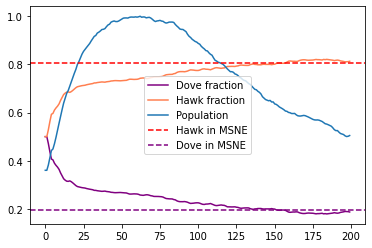

In [94]:
plt.clf()
plt.plot(npdovePer, color = "purple", label = "Dove fraction")
plt.plot(nphawkPer, color = "coral", label = "Hawk fraction")
plt.plot(nppopulation, label = "Population")
MSNE = game().findMSNE()
plt.axhline(y=MSNE[0][0],color = 'red', linestyle='--', label = "Hawk in MSNE")
plt.axhline(y=MSNE[0][1],color = 'purple', linestyle='--', label = "Dove in MSNE")
plt.legend()



plt.show()

In [95]:
print(MSNE)

[array([0.80487805, 0.19512195]), array([0.80487805, 0.19512195])]


In [ ]:
STARTING_DOVES = 1000
STARTING_HAWKS = 1000
STARTING_POPULATION = STARTING_HAWKS + STARTING_DOVES

ROUNDS = 500
STARTING_ENERGY = 100

MIN_FOOD_PER_ROUND = 10
MAX_FOOD_PER_ROUND = 70
MAX_FOOD_APPEARANCE = 2000 # this tells how much max food can be found
ENERGY_REQUIRED_FOR_REPRODUCTION = 250
ENERGY_LOSS_PER_ROUND = 4
ENERGY_LOSS_FROM_FIGHTING = 35
ENERGY_REQUIRED_FOR_LIVING = 10